<a href="https://colab.research.google.com/github/denisbebrovich/ML-DS/blob/main/%D0%9C%D0%9E%D0%B4%D0%B75_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Часть из дз4
Взял датасет из ДЗ4, количество компонентов взял 40

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

In [ ]:
x, y = fetch_openml(name = 'Fashion-MNIST', version = 1, return_X_y=True, as_frame = True)
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [ ]:
x = x / 255

In [ ]:
dict1 = {'0': 'Футболка',
'1': 'Брюки',
'2': 'Пуловер',
'3': 'Платье',
'4': 'Пальто',
'5': 'Сандали',
'6': 'Блуза',
'7': 'Кроссовки',
'8': 'Сумка',
'9': 'Ботинки'}

y = y[y['class'].isin(dict1.keys())]
y['class'] = y['class'].replace(dict1)

<ipython-input-4-8f0239faf8eb>:13: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y['class'] = y['class'].replace(dict1)


In [ ]:
df = pd.concat([x, y], axis = 1)

In [ ]:
comps = 40
pca = PCA(n_components = comps)
pca.fit(x)

PCA(n_components=40)

решил взять 40, чтобы было более явно видно изображения


In [ ]:
pca_df = pca.transform(x)

In [ ]:
data = pd.DataFrame()
pca_columns = ['pca-{}'.format(x+1) for x in range(0, comps)]
data.loc[:, pca_columns] = pca_df
data['y'] = y

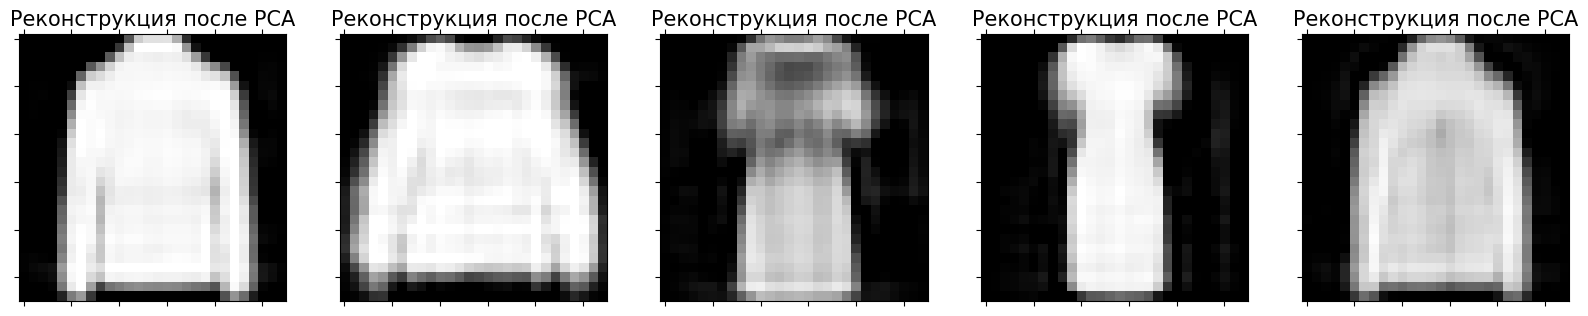

In [ ]:
n =  random.randint(0, len(pca_df)-5)

pca_inverse = np.dot(pca_df, pca.components_) + pca.mean_

fig=plt.figure(figsize=(20,13))
for i in range(0,5):
  ax = fig.add_subplot(3,5,i+6)
  ax.set_title("Реконструкция после PCA", size=15)
  ax.matshow(1-pca_inverse[i+n,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

#Применение кластеризации

##Шаг 0

In [ ]:
n_clusters = 10
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

##Шаг 1

In [ ]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    """ Оценка расстояния
    Входные переменные:
    ===========
    X1: первый вектор / матрица векторов
    X2: второй вектор / матрица векторов
    metric: тип метрики расстояния
    p: степень для Метрики минковского
    """
    # тут как "по формулам из учебника"
    if metric == 'euclidean':
        # Эвклидово расстояние это корень из суммы квадратов разностей
        dist = np.power(np.sum(np.square(X1 - X2).T,axis=0), 0.5)
    if metric == 'cityblock':
        # Манхеттонское расстояние это сумма модулей разностей
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        # расстояние Чебышева это максимум из модулей разностей
        dist = np.max(np.abs(X1 - X2).T,axis=0)
    if metric == 'Minkowski':
    # расстояние Минковского это корень p-ой степени из суммы разностей в степени p
        dist = np.power(np.sum(np.abs(X1 - X2) ** p, axis=0), 1 / p)
    return dist # возвращает 1 число, если ищем расстояние между векторами
    # и несколько чисел, если векторов несколько

In [ ]:
def init_centroids(X, n_clusters, random_state = 42):
    """Инициализация центроидов
    Входные переменные:
    ===========
    X: признаки
    n_clusters: ожидаемое количество кластеров
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    if random_state: rng = np.random.seed(random_state) # фиксируем случайный seed
    # выбираем n_clusters случайных индексов из диапазона от 0 до количества точек в даннных
    centroid_idxs = np.random.randint(0, X.shape[0], size = n_clusters)
    return X[centroid_idxs,:] # центры кластеров - точки с выбранными индексами


In [ ]:
def predict(X, n_clusters, centroids, metric = 'euclidean', p = 2):
    """Предсказание кластера
    Входные переменные:
    ===========
    X: признаки
    n_clusters: ожидаемое количество кластеров
    centroids: текущие центры кластеров
    metric: тип метрики расстояния
    p: степень для Метрики минковского
    """
    # заполняем матрицу расстояний нулями. размерность матрицы число точек на число кластеров
    distances = np.zeros((X.shape[0], n_clusters))
    # перибираем каждый центроид
    for i, centr in enumerate(centroids):
        distances[:,i] = distance(centr,X, metric, p)#расчитываем расстояние от центра до всех точек
        # используем ранее написанную функцию поиска расстояний
    cluster_label = np.argmin(distances,axis = 1) # находим ближайший центр для каждой точки
    return cluster_label, distances # возвращаем метки кластеров и матрицу расстояний

In [ ]:
def plot_clusterX(X, centroids, cluster_label, old_centroids=None):
    """Визуализация кластера"""
    fig = plt.figure(figsize=(11, 10))  # Создаем полотно
    # Визуализируем наши признаки
    scatter = plt.scatter(X[:, 0], X[:, 1],
                c=cluster_label, cmap='viridis',  # Используйте 'viridis' или другую цветовую карту
                s=100, alpha=0.3)

    # Визуализируем текущие центры кластеров
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c='red',  # Используем фиксированный цвет для центров
                s=400, edgecolors='w', label='Centroids')

    if old_centroids is not None:  # если хотим визуализировать предыдущие центры кластеров
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
                    c='blue',  # Используем фиксированный цвет для старых центров
                    s=200, edgecolors='w', label='Old Centroids')

    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.colorbar(scatter)  # Добавляем цветовую шкалу
    plt.title('Cluster Visualization')
    plt.show()


In [ ]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    """Визуализация кластера
    Входные переменные:
    ===========
    X: признаки
    centroids: текущие центры кластеров
    cluster_label: метки кластеров для признаков
    centroids_label: метки для текущих центров кластеров
    old_centroids: предыдущие центры кластеров
    old_centroids_label: метки для предыдущих центров кластеров
    """
    fig = plt.figure(figsize=(11,10)) # Создаем полотно
    # Визуализируем наши признаки
    plt.scatter(X[:, 0], X[:, 1],
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.3)
    # Визуализируем текущие центры кластеров. Как точки, но побольше
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'w')

    if old_centroids is not None: # если хотим визуализировать предыдущие центры кластеров
        # их отрисуем поменьше, чем текущие центры, но больше чем "рядовые точки"
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'w')

    plt.xticks([])
    plt.yticks([])

##Шаг 2

In [ ]:
X = np.array(X)

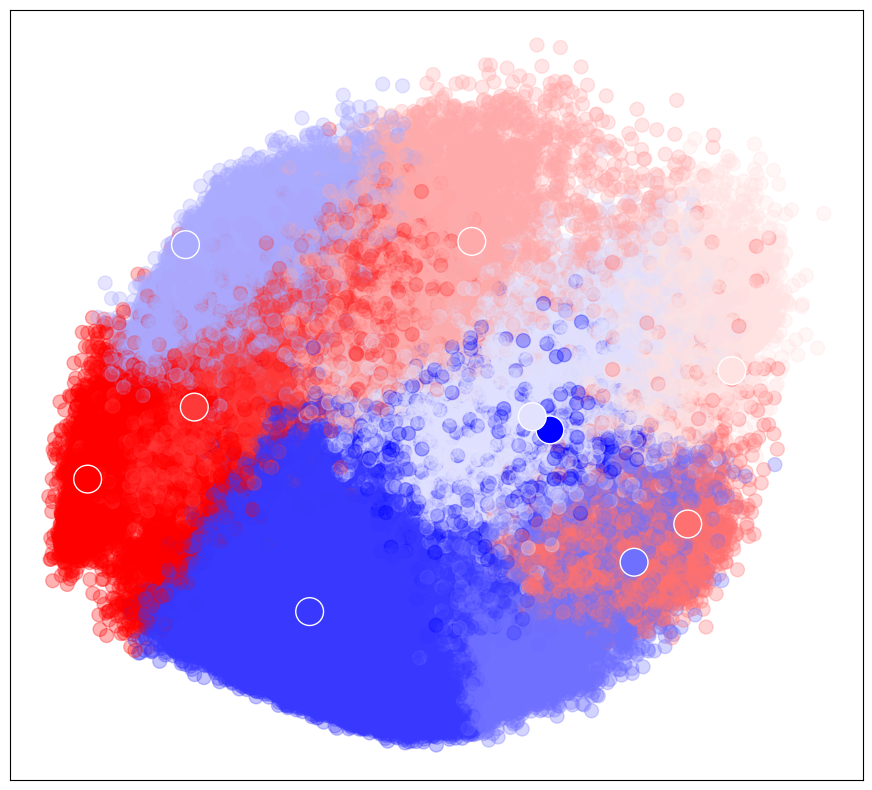

In [ ]:
# фиксируем случайный seed
random_state = 32
rng = np.random.seed(random_state)

# выбираем n_clusters случайных индексов из диапазона от 0 до количества точек в данных
centroid_idxs = np.random.randint(0, X.shape[0], size=n_clusters)
centroids = X[centroid_idxs, :]  # центры кластеров - точки с выбранными индексами

cluster_label, distances = predict(X, n_clusters, centroids)
centroids_label = []
for i in range(0, len(np.unique(data['y']))):
  centroids_label.append(i)

plot_cluster(X, centroids, cluster_label, centroids_label)

Неплохо расположились центры,нужно проверять можно ли лучше. по ощущениям - можно

##Шаг 3


In [ ]:
old_centroids = np.copy(centroids)

for k in range(n_clusters): # перебираем все кластеры
    c_idxs = np.flatnonzero(cluster_label==k) #берем индексы тек точек, которые принадлежат к класетру k
    centroids[k] = X[c_idxs].mean(axis = 0) # считаем среднего представителя для кластера

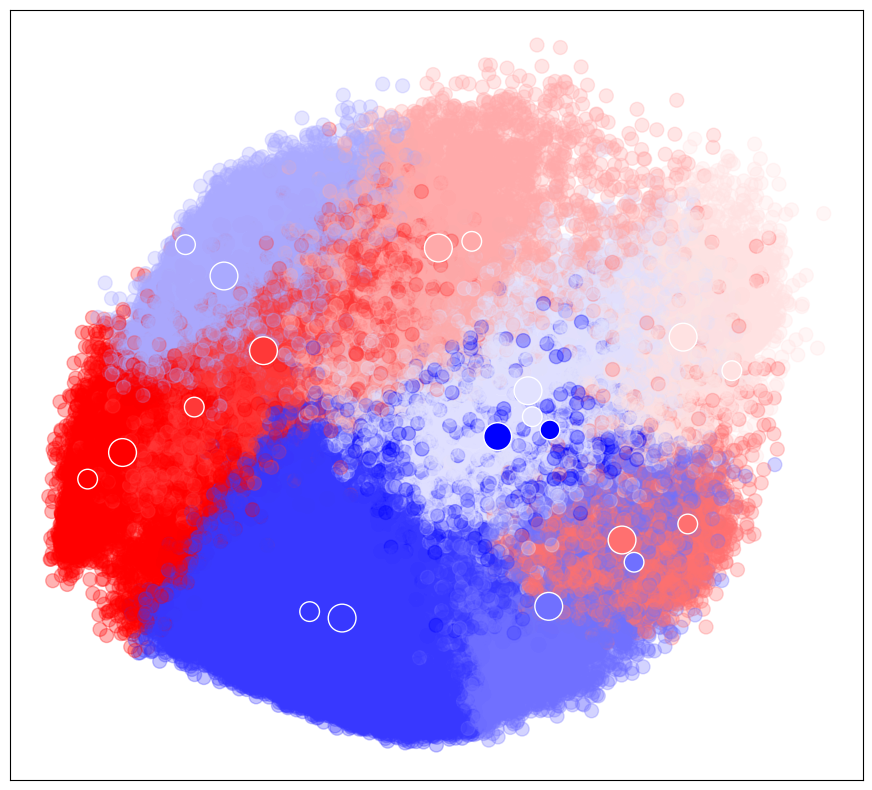

In [ ]:
plot_cluster(X,centroids,
             cluster_label, centroids_label,
             old_centroids, centroids_label)

видимо, есть к чему стремиться

In [ ]:
def delta_centroids(centroids,old_centroids, metric = 'euclidean', p = 2):
    """Оценка изменений положения центров кластеров
    Входные переменные:
    ===========
    centroids: текущие центры кластеров
    old_centroids: предыдущие центры кластеров
    old_centroids_label: метки для предыдущих центров кластеров
    metric: тип метрики расстояния
    p: степень для Метрики минковского
    """
    # используем функцию расстояния для оценки изменения смещений центров кластеров
    return (distance(centroids,old_centroids, metric, p)/distance(old_centroids, np.mean(old_centroids), metric, p)).mean()

delta_centroids(centroids,old_centroids)

0.48934025207114135

In [ ]:
def fit(X, n_clusters, centroids, max_iter=10, tol=0.01, metric = 'euclidean', p = 2):
    """Обучение кластеризации к-средних
    Входные переменные:
    ===========
    X: признаки
    n_clusters: ожидаемое количество кластеров
    centroids: текущие центры кластеров
    max_iter: максимальное количество итераций алгоритма К-Средних
    tol: порог изменения расстояния
    metric: тип метрики расстояния
    p: степень для Метрики минковского
    """
    dcentr = np.inf # пусть вначале разница между изменениями положения - некое большое число

    for i in range(max_iter): #  делаем до max_iter итераций алгоритма

        old_centroids = np.copy(centroids) # текущие центры становятся стапыми
        cluster_label,_=predict(X, n_clusters, centroids, metric, p) # предсказываем метки кластеров

        # считаем новые центры кластеров как средние точки по кластерам
        for k in range(n_clusters):
            c_idxs = np.flatnonzero(cluster_label==k)
            centroids[k] = X[c_idxs].mean(axis = 0)
        # оцениваем относительное изменение центроидов
        dcentr = delta_centroids(centroids,old_centroids, metric, p)
        # если изменение меньше порога - закончим раньше
        if dcentr<=tol:
            break

    print('Мы остановились на итерации:', i,', относительное изменение центроидов: ',dcentr)

    return cluster_label # возвращаем финальные метки кластеров

In [ ]:
cluster_label = fit(X, n_clusters, centroids, max_iter=100, tol=0.001)

Мы остановились на итерации: 39 , относительное изменение центроидов:  0.0009806435416132482


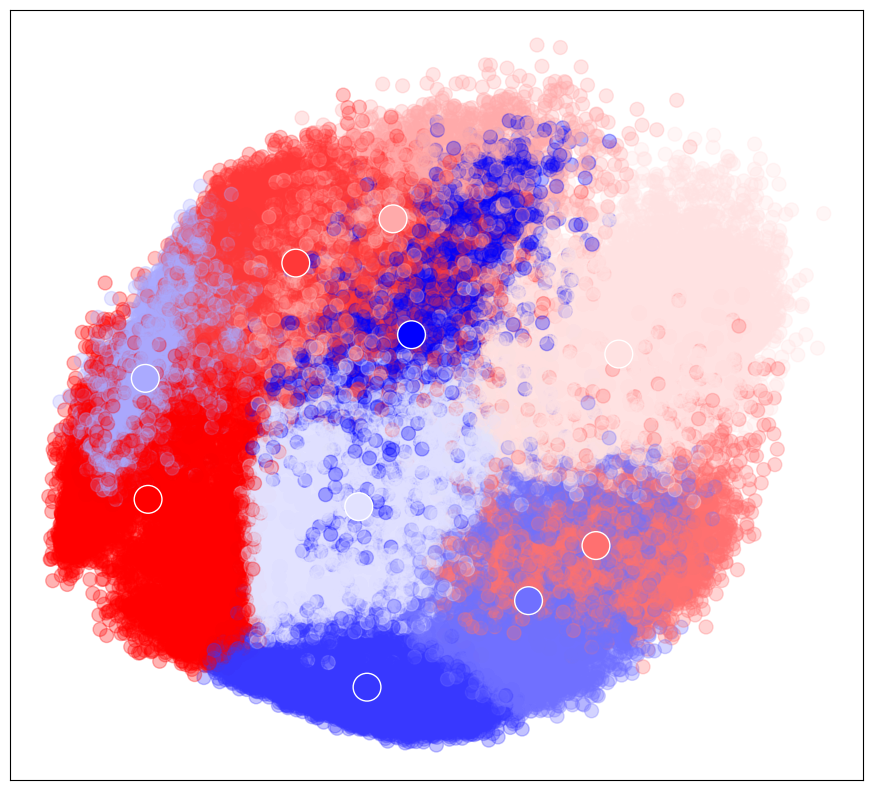

In [ ]:
plot_cluster(X,centroids,
             cluster_label, centroids_label,)

правда, очень похоже на центры этих кучек

In [ ]:
nnn_clusters = 25

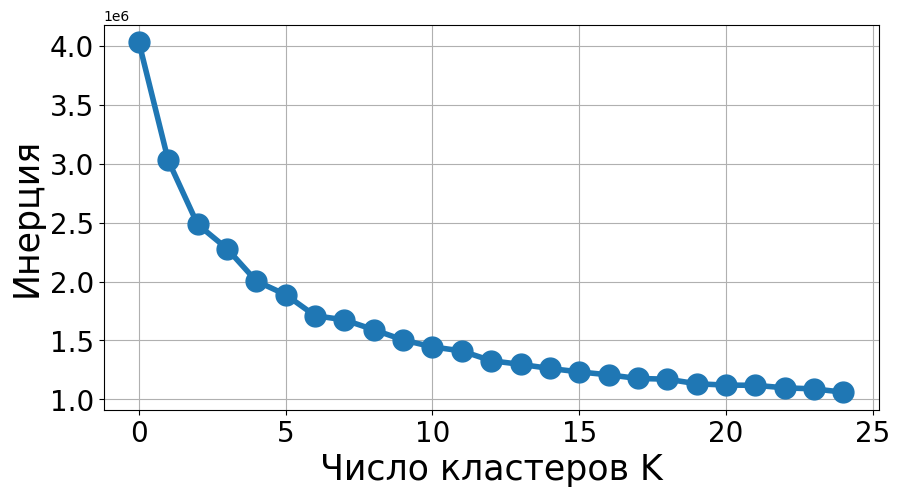

In [ ]:
from sklearn.cluster import KMeans
sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(nnn_clusters))
for k in list_k: # тестируем различные к в диапазоне от 1 до 5
    km = KMeans(n_clusters=k+1)# создаем объект кластеризации с заданным к
    km.fit(X) # обучаем
    sse.append(km.inertia_) # фиксируем текущую инерцию

# визуализируем метод локтя. ниже используется много раз встречающаяся визуализация
plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

взял побольше кластеров, чтобы локоть был виднее.
по методу локтя выбираем 4 кластера

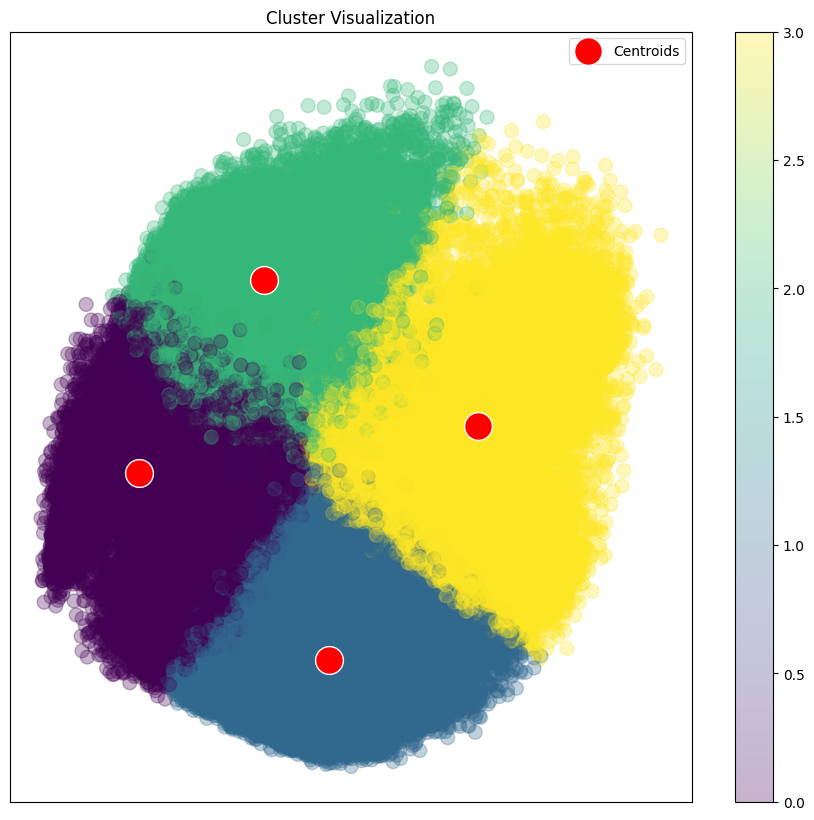

In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=100, tol=0.01, random_state= 42) # создаем объект
kmeans.fit(X)  # обучаем модель

c_labels = kmeans.labels_  # Получаем метки кластеров
centroids = kmeans.cluster_centers_  # Получаем центры кластеров

# Визуализируем
plot_clusterX(X, centroids, c_labels)

вообще эти данные сложно делить на что-то, ибо по графику все точки находятся в одной куче, а кучу разделить можно на сколько угодно частей.

##Выводы

In [ ]:
y = np.array(y)

In [ ]:
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

хотелось бы написать вывод но объём озу исчерпан и я не знаю что с этим делать...

Я по графикам сделал вывод, что сам датасет не подходит для задачи кластеризации, но при известных кластерах центроиды находятся очень даже хорошо, хоть и только на 39ю итерацию.